## Домашнее задание: Работа с OpenCV для анализа контрольных точек и построения карт движения

**Задание 1**. Обнаружение и построение контрольных точек
Используя OpenCV, выберите два кадра из видео (или просто пару изображений), и реализуйте методы обнаружения контрольных точек, такие как SIFT, ORB или FAST. Постройте и визуализируйте найденные контрольные точки, отметив их на изображениях. Затем установите соответствие точек между двумя кадрами.

**Задание 2**. Построение фундаментальной матрицы
На основе найденных в Задании 1 контрольных точек между двумя изображениями, вычислите фундаментальную матрицу. Используйте ее для построения эпиполярных линий и визуализируйте их на изображениях. Объясните, в каких случаях фундаментальная матрица может быть полезна.

**Задание 3**. Оценка движения с использованием Optical Flow
Возьмите видео и выберите непрерывные кадры. Используя методы Optical Flow (например, метод Лукаса-Канаде или Dense Optical Flow), определите и визуализируйте движение объектов между кадрами. Проанализируйте, как и куда смещаются объекты в кадре.

**Задание 4**. Построение карты движения
На основе выполненного в Задании 3, постройте карту движения на протяжении нескольких кадров. Определите области с постоянным движением и проанализируйте их с точки зрения особенностей сцены (например, движущиеся объекты, статичный фон).

**Задание 5**. Обнаружение объектов на основе движения
Реализуйте метод для обнаружения объектов на основе анализа движения. С помощью результатов карты движения из предыдущих заданий, выделите объекты, которые совершают движение. Попробуйте распознать их контуры и отобразить в отдельном кадре.

# Задание 1. Обнаружение и построение контрольных точек

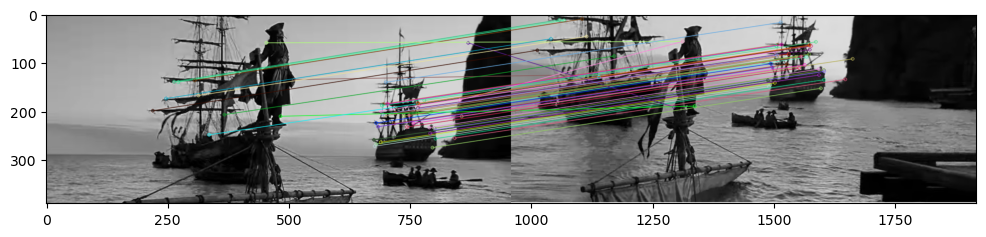

In [26]:
import cv2
import matplotlib.pyplot as plt

# Загрузите изображения
img1 = cv2.imread('pic1.jpg', cv2.IMREAD_GRAYSCALE)
img1 = cv2.resize(img1, (0,0), None, 0.5, 0.5)
img2 = cv2.imread('pic2.jpg', cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(img2, (0,0), None, 0.5, 0.5)

# Инициализация детектора
# ДОПОЛНИТЬ: Выберите метод для создания детектора (например, SIFT или ORB)
sift = cv2.SIFT_create()

keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
keypoints2, descriptors2 = sift.detectAndCompute(img2, None)

# Построение контрольных точек
# ДОПОЛНИТЬ: Используйте подходящий матчинг (например, BFMatcher)
bf = cv2.BFMatcher()
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

# Визуализация совпадений
img_matches = cv2.drawMatches(img1, keypoints1, img2, keypoints2, matches[:50], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.figure(figsize=(12, 10))
plt.imshow(img_matches)
plt.show()

cv2.imshow('Matches', img_matches)
cv2.waitKey(0)
cv2.destroyAllWindows()


Алгоритм SIFT отработал сопоставление изображений и определил соответствующие точки. Мы видим, что в качестве ключевых точек алгоритм установил контуры кораблей и скалы. Цвета линий обозначают вес уверенности сопоставления.
Видно, что алгоритм отработал с достаточно высокой точностью. Но имеются недочеты, например, имеются точки на контуре фигуры __капитана__ Джека Воробья, которые соотнесены с кораблем.

# Задание 2. Построение фундаментальной матрицы

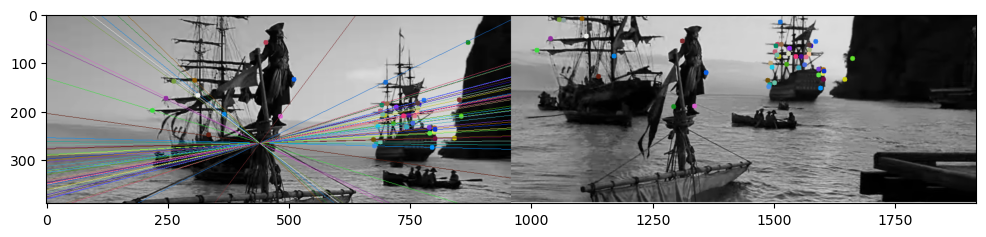

In [25]:
import numpy as np

# Получаем точки совпадений

# ДОПОЛНИТЬ: Выберите нужное количество контрольных точек
pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches[:50]])
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches[:50]])

# Вычисление фундаментальной матрицы
# ДОПОЛНИТЬ: Выберите метод вычисления фундаментальной матрицы
F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC)

# Построение эпиполярных линий
def drawlines(img1, img2, lines, pts1, pts2):
    r, c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0, 255, 3).tolist())
        x0, y0 = map(int, [0, -r[2] / r[1]])
        x1, y1 = map(int, [c, -(r[2] + r[0] * c) / r[1]])
        img1 = cv2.line(img1, (x0, y0), (x1, y1), color, 1)
        img1 = cv2.circle(img1, tuple(map(int, pt1)), 5, color, -1)
        img2 = cv2.circle(img2, tuple(map(int, pt2)), 5, color, -1)
    return img1, img2

# ДОПОЛНИТЬ: Используйте подходящий метод для вычисления эпиполярных линий
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img5, img6 = drawlines(img1, img2, lines1, pts1, pts2)
plt.figure(figsize=(12, 10))
plt.imshow(np.hstack((img5, img6)))
plt.show()


cv2.imshow('Epilines', np.hstack((img5, img6)))
cv2.waitKey(0)
cv2.destroyAllWindows()

* Фундаментальная матрица помогает провести геометрическую валидацию изображений. Она помогаета отсеять ложные соответствия. При умножении на фундаментальную матрицу верного соответствия результат должен быть близок или равен нулю.
* Помимо отбрасывания ложных соответствий можно и найти произвольный жёсткий объект.

# Задание 3. Оценка движения с использованием Optical Flow

Функция calcOpticalFlowFarneback() использует два кадра и сравнивает положение объектов в этих кадрах. Если положение объекта меняется, функция сохраняет этот объект в двумерном массиве.

Мы можем использовать cartToPolar() и двумерный массив, возвращаемый calcOpticalFlowFarneback() для поиска размеров и углов объектов, присутствующих в заданном видео.

In [23]:
cap = cv2.VideoCapture('race_car.mp4')
ret, frame1 = cap.read()

# преобразуем предыдущий кадр изображения в оттенки серого
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)


hsv = np.zeros_like(frame1)
hsv[..., 1] = 255

# Для использования метода Farneback зададим необходимые переменные

# выходной массив, куда сохраняются объекты потока
flow = None 

# коэффициент масштабирования для построения гауссовой пирамиды изображений
pyr_scale = 0.5

# количество слоёв пирамиды, включая исходное изображение
# мы не хотим использовать дополнительные слои, поэтому установили его значение равным 1
levels = 3

# размер окна усреднения, используемого для расчёта потока
# его значение определяет скорость алгоритма (чем ниже значение, тем ниже скорость и четче результат)
winsize = 15

# количество итераций, используемых в алгоритме расчёта потока на каждом слое
iterations = 3

# размер окна, используемого для поиска полинома разложения
poly_n = 5

# стандартное отклонение гауссианы, используемой для сглаживания производных
poly_sigma = 1.2

# комбинация флагов интерполяции, таких как OPTFLOW_USE_INITIAL_FLOW или OPTFLOW_FARNEBACK_GAUSSIAN
flags = 0

while cap.isOpened():
    ret, frame2 = cap.read()
    if not ret:
        break
    # преобразуем вновь полученное изображения в оттенки серого
    next_frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # ДОПОЛНИТЬ: Используйте подходящий метод Optical Flow (например, Farneback)
    flow = cv2.calcOpticalFlowFarneback(prvs, next_frame, 
                                        flow, pyr_scale,
                                        levels, winsize,
                                        iterations, poly_n,
                                        poly_sigma, flags)
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    bgr = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    cv2.imshow('Optical Flow', bgr)
    if cv2.waitKey(30) & 0xFF == 27:
        break
    prvs = next_frame

cap.release()
cv2.destroyAllWindows()


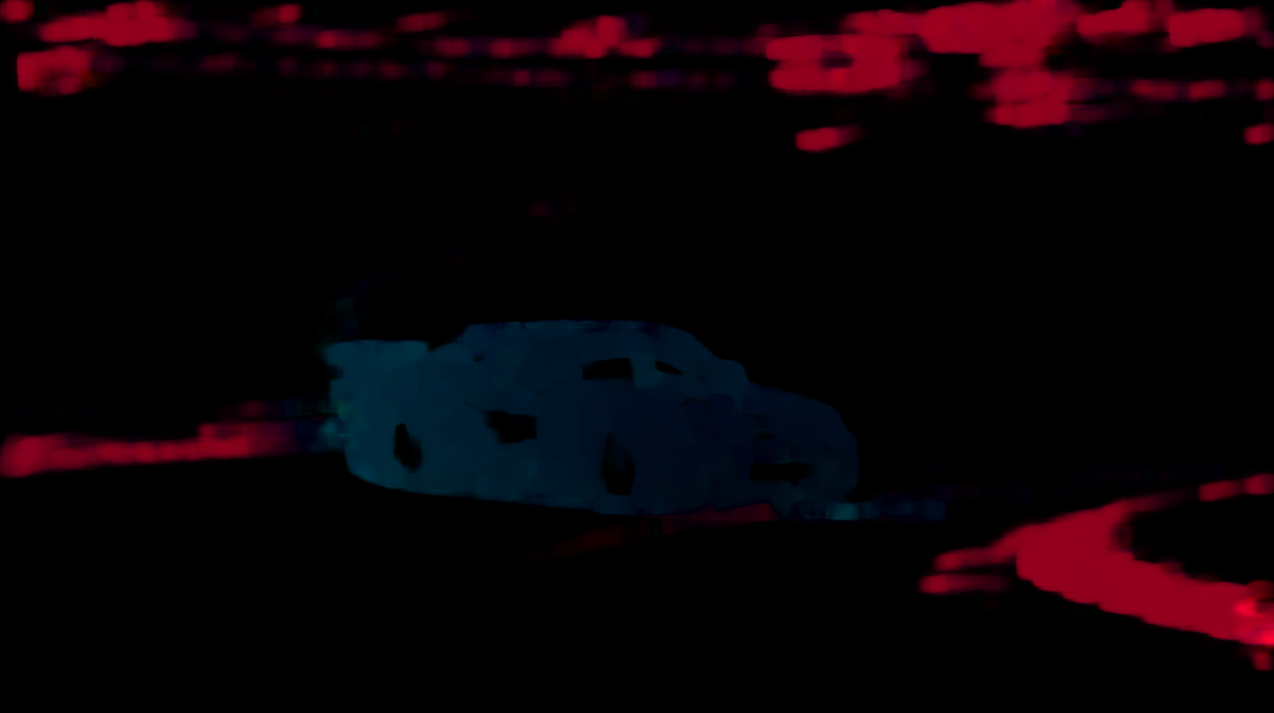

Смещение объектов раскрашивается другими цветами. Причем, чем быстрее движение, тем более близок к белому цвет объекта.

Как видно на серии изображений, при появлении в кадре автомобиля, он раскрашивается в разные цвета. Мы можем наблюдать его движение в кадре. При этом присутствует изменение цвета фона - это реакция алгоритма на движущуюся камеру.
Объекты в кадре (если считать движущийся фон тоже объектом) движутся в разных направлениях, в соответствии с изображениями, которые мы видим в видео.

* Функция zeros_like() создаёт чёрный контур для отображения движущегося объекта.
* Функция calcOpticalFlowFarneback() находит движущиеся объекты, prvs, next_frame - соответственно, предыдущий и следующий кадры потока
* Функция normalize() используется для нормализации величины движущихся объектов с помощью MINMAX-нормализации.
* Функция cartToPolar используется для преобразования декартовых координат в полярные и создания дескрипторов.

# Задание 4. Построение карты движения 

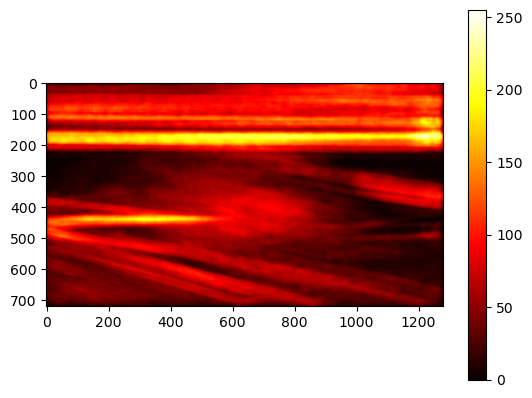

In [12]:
motion_map = np.zeros_like(prvs, dtype=np.float32)

cap = cv2.VideoCapture('race_car.mp4')
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

flow = None 
pyr_scale = 0.5
levels = 3
winsize = 15
iterations = 3
poly_n = 5
poly_sigma = 1.2
flags = 0

while cap.isOpened():
    ret, frame2 = cap.read()
    if not ret:
        break
    next_frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # ДОПОЛНИТЬ: Используйте метод Optical Flow, как в Задании 3
    flow = cv2.calcOpticalFlowFarneback(prvs, next_frame, 
                                        flow, pyr_scale,
                                        levels, winsize,
                                        iterations, poly_n,
                                        poly_sigma, flags)
    
    mag, _ = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    motion_map += mag
    prvs = next_frame

# Нормализуем и отображаем карту движения
motion_map = cv2.normalize(motion_map, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
plt.imshow(motion_map, cmap='hot')
plt.colorbar()
plt.show()

cap.release()


В данном задании мы также использовали функцию calcOpticalFlowFarneback для определения движущихся объектов.

При этом происходит последовательное наложение кадров и построение диаграммы, где мы видим светлые и темные области.

Чем темнее область, тем менее она подвижна в потоке.

На диаграмме четко видно смещение горизонта (вслед за камерой) и траектория движения автомобиля, особенно в повороте, когда появляется дым из-под колес.

В данном случае камера следует за автомобилем, поэтому мы имеем ситуацию, что на диаграмме автомобиль менее подвижен, чем фон.

# Задание 5. Обнаружение объектов на основе движения 

In [24]:
cap = cv2.VideoCapture('race_car.mp4')
ret, frame1 = cap.read()
prvs = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

flow = None 
pyr_scale = 0.5
levels = 3
winsize = 15
iterations = 3
poly_n = 5
poly_sigma = 1.2
flags = 0

while cap.isOpened():
    ret, frame2 = cap.read()
    if not ret:
        break
    next_frame = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)
    
    # ДОПОЛНИТЬ: Используйте метод Optical Flow для расчета движения между кадрами
    flow = cv2.calcOpticalFlowFarneback(prvs, next_frame, 
                                        flow, pyr_scale,
                                        levels, winsize,
                                        iterations, poly_n,
                                        poly_sigma, flags)
    
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])

    # ДОПОЛНИТЬ: Установите пороговое значение для выделения движущихся объектов
    threshold = 4
    moving_objects = mag > threshold
    contours, _ = cv2.findContours(moving_objects.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Рисуем контуры на кадре
    frame2 = cv2.cvtColor(next_frame, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(frame2, contours, -1, (0, 255, 0), 2)

    cv2.imshow('Detected Moving Objects', frame2)
    if cv2.waitKey(30) & 0xFF == 27:
        break
    prvs = next_frame

cap.release()
cv2.destroyAllWindows()


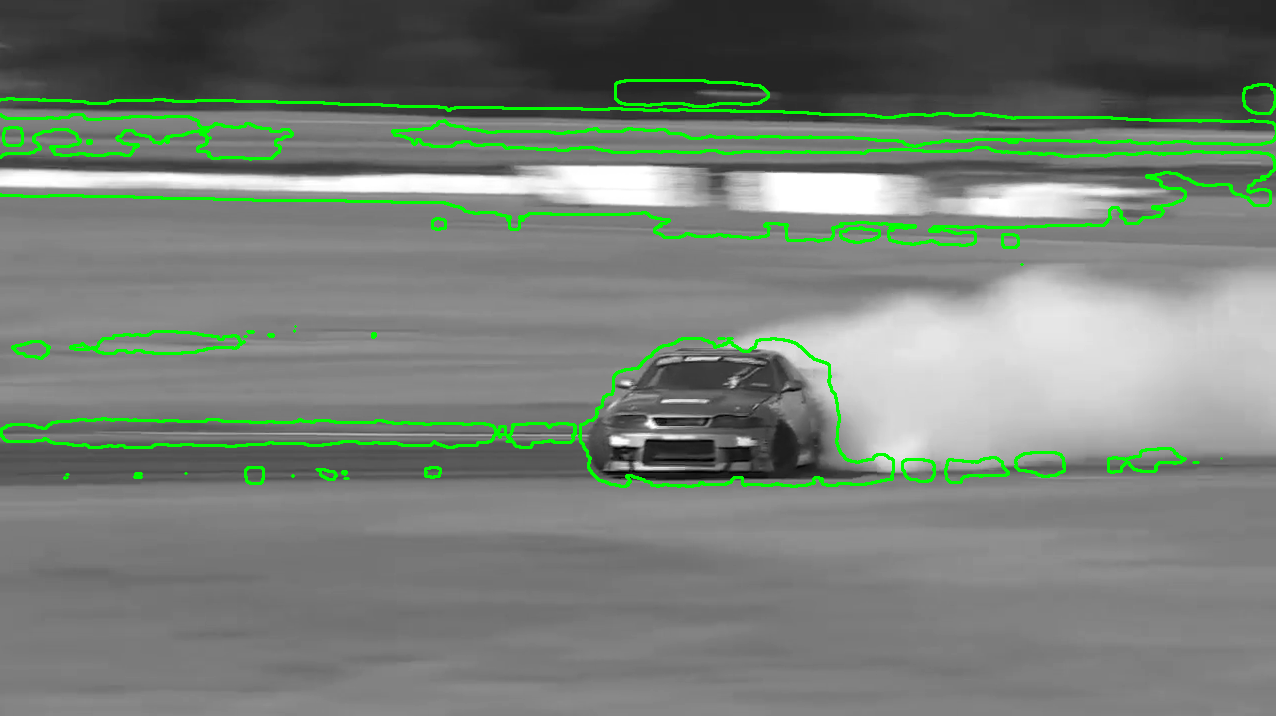

Чем выше пороговое значение для выделения движущихся объектов, тем менее чувствительным к движению становится алгоритм.

На кадре видно, что движущийся фон и поворачивающий автомобиль выделяются, как движущиеся объекты.

## Выводы

Библиотека OpenCV предоставляет большой набор инструментов для анализа контрольных точек на изображениях и построения карты движения.
С помощью функций OpenCV мы можем следующее:
* находить значимые точки на изображении (обнаружение особенностей) - реализовано в задачах 1 и 2, где мы обнаруживали характерные точки на разных кадрах потока с помощью алгоритма SIFT и функций BFMatcher()б drawMatches;
* сравнивать найденные точки между разными кадрами (сопоставление особенностей) - также реализовано в задачах 1 и 2;
* определять перемещения камеры или объектов (оценка движения) - реализовано в задачах 3 - 5, где с помощью функции calcOpticalFlowFarneback мы определили движущиеся объекты видео, а затем с помощью комбинаций функции normalize получали их выделение (визуализацию) в задачах 3,4 , а также выделение и нанесения на изображения границ движущихся объектов с помощью функций findContours и drawContours  (задача 5).

__Ссылки на материалы:__
* pic1.jpg - https://disk.yandex.ru/i/C0oLijBIEWoFGg
* pic2.jpg - https://disk.yandex.ru/i/clR3cE7LFoKB5A
* race_car.mp4 - https://disk.yandex.ru/i/JSdShnLVp_MOhg